In [5]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,RepeatVector,Bidirectional,TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pandas as pd 
import numpy as np

In [2]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [6]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = np.array(deu_eng)

In [7]:
deu_eng = deu_eng[:50000,:]

In [8]:
deu_eng

array([['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ...,
       ['This is all your fault.', 'Das ist alles deine Schuld!'],
       ['This is an ancient law.', 'Das ist ein altes Gesetz.'],
       ['This is an improvement.', 'Das ist eine Verbesserung.']],
      dtype='<U537')

In [10]:
import string
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [11]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [12]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [13]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

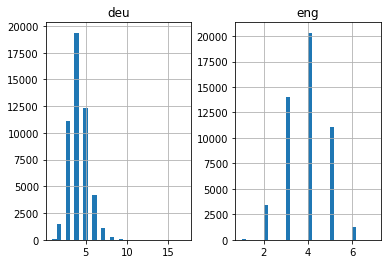

In [15]:
length_df.hist(bins = 30)
plt.show()

In [16]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [17]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6391


In [18]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10731


In [19]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [20]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [21]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [22]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [23]:
model = Sequential()
model.add(Embedding(deu_vocab_size, 512, input_length=deu_length, mask_zero=True))
model.add(LSTM(512))
model.add(RepeatVector(deu_length))
model.add(LSTM(512, return_sequences=True))
model.add(Dense(eng_vocab_size, activation='softmax'))




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [32]:
model.compile(optimizer='RMSprop', loss='sparse_categorical_crossentropy')

In [33]:
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2)




Train on 32000 samples, validate on 8000 samples
Epoch 1/30





32000/32000 [==============================] - 216s 7ms/step - loss: 3.5423 - val_loss: 3.0247
Epoch 2/30
32000/32000 [==============================] - 198s 6ms/step - loss: 2.9112 - val_loss: 2.8586
Epoch 3/30
32000/32000 [==============================] - 197s 6ms/step - loss: 2.7455 - val_loss: 2.6917
Epoch 4/30
32000/32000 [==============================] - 197s 6ms/step - loss: 2.5808 - val_loss: 2.5840
Epoch 5/30
32000/32000 [==============================] - 207s 6ms/step - loss: 2.4604 - val_loss: 2.5127
Epoch 6/30
32000/32000 [==============================] - 201s 6ms/step - loss: 2.3388 - val_loss: 2.3932
Epoch 7/30
32000/32000 [==============================] - 200s 6ms/step - loss: 2.2117 - val_loss: 2.3129
Epoch 8/30
32000/32000 [==============================] - 217s 7ms/step - loss: 2.1011 - val_loss: 2.2270
Epoch 9/30
32000/32000 [==============================] - 199s 6ms/step - loss: 1.9856 - val_lo

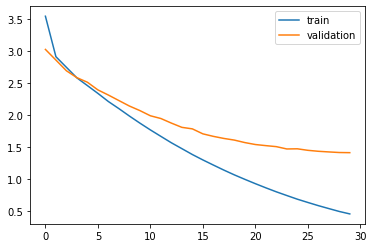

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [38]:
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [39]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [40]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [41]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [42]:
pd.set_option('display.max_colwidth', 200)

In [43]:
pred_df.head(15)

,actual,predicted
0,hows your job going,what is do
1,i love him,i love him
2,mary likes you,mary likes you
3,i met a friend,i got into big
4,tom doesnt buy bread,tom has no bread
5,i cant come tomorrow,i can come alone
6,youll love australia,youll love australia
7,ive got a great idea,i have a good idea
8,do you like candy,do you like
9,no one encouraged her,nobody encouraged her
